In [ ]:
!pip install git+https://github.com/openai/point-e.git

In [7]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:06<00:00, 147MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [4]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [9]:
# Load an image to condition on.
img_path = '/content/starpinktable.jpg'
img = Image.open(img_path)

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

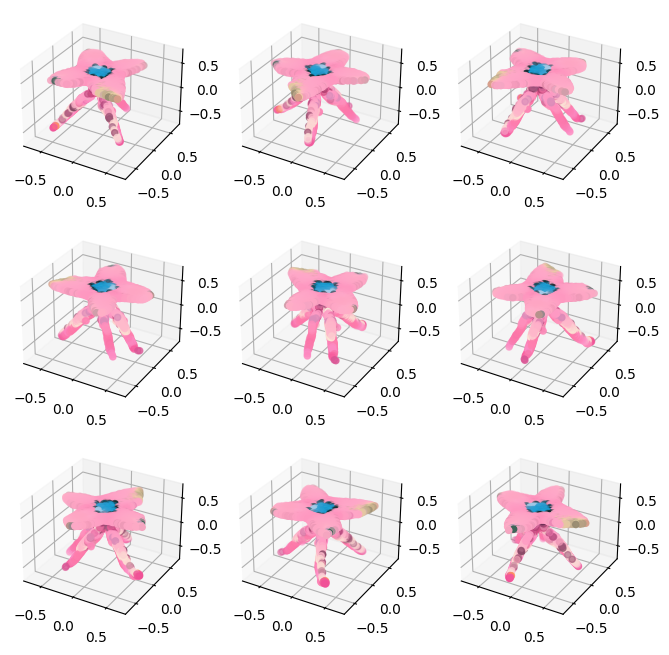

In [10]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [11]:
type(pc)

point_e.util.point_cloud.PointCloud

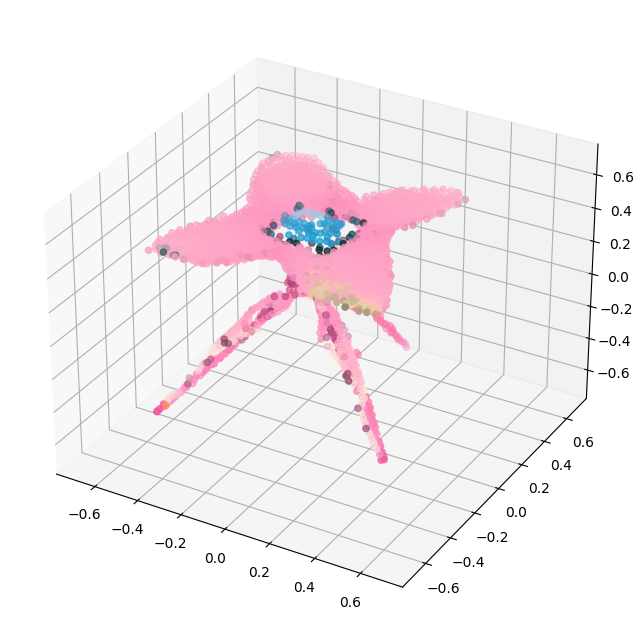

In [12]:
fig = plot_point_cloud(pc)

In [21]:
import pickle

In [23]:
pickle.dump(pc, open('pc.pkl', 'wb'))

In [38]:
pc

PointCloud(coords=array([[-0.48717195, -0.2353392 , -0.01554416],
       [-0.4882631 , -0.44021377,  0.02891267],
       [ 0.2910984 ,  0.48928827,  0.29396155],
       ...,
       [-0.38727412, -0.487056  , -0.49915418],
       [-0.49559793,  0.20609306, -0.00603467],
       [ 0.03489218,  0.3797285 , -0.5       ]], dtype=float32), channels={'R': array([0.89019614, 0.74509805, 0.7686275 , ..., 1.        , 0.72156864,
       1.        ], dtype=float32), 'G': array([0.59607846, 0.49411768, 0.5254902 , ..., 1.        , 0.9725491 ,
       1.        ], dtype=float32), 'B': array([0.4666667 , 0.38431376, 0.40784317, ..., 0.9960785 , 1.        ,
       1.        ], dtype=float32)})

In [43]:
pc.save('/content/pc')

In [46]:
from numpy import load

data = load('/content/pc.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

coords
[[-0.48717195 -0.2353392  -0.01554416]
 [-0.4882631  -0.44021377  0.02891267]
 [ 0.2910984   0.48928827  0.29396155]
 ...
 [-0.38727412 -0.487056   -0.49915418]
 [-0.49559793  0.20609306 -0.00603467]
 [ 0.03489218  0.3797285  -0.5       ]]
R
[0.89019614 0.74509805 0.7686275  ... 1.         0.72156864 1.        ]
G
[0.59607846 0.49411768 0.5254902  ... 1.         0.9725491  1.        ]
B
[0.4666667  0.38431376 0.40784317 ... 0.9960785  1.         1.        ]


In [50]:
data['coords']

array([[-0.48717195, -0.2353392 , -0.01554416],
       [-0.4882631 , -0.44021377,  0.02891267],
       [ 0.2910984 ,  0.48928827,  0.29396155],
       ...,
       [-0.38727412, -0.487056  , -0.49915418],
       [-0.49559793,  0.20609306, -0.00603467],
       [ 0.03489218,  0.3797285 , -0.5       ]], dtype=float32)